In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

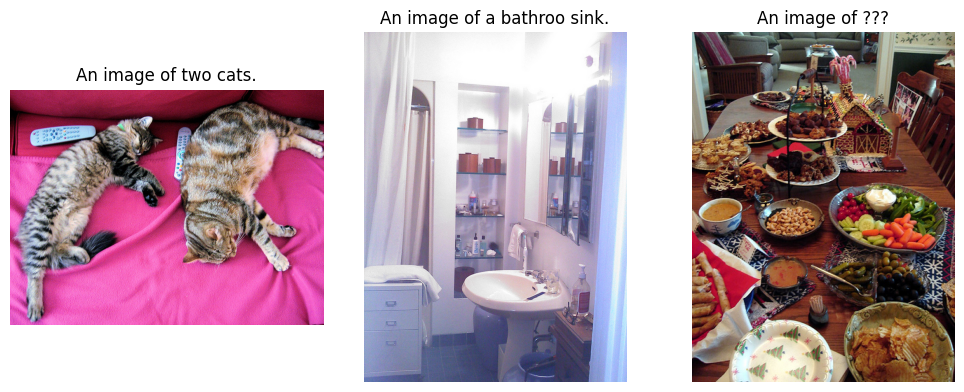

In [4]:
def load_image(url):
    response = requests.get(url, stream=True)
    return Image.open(response.raw)

def plot_images(images, titles, figsize=(10,4)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images_urls = [
    'http://images.cocodataset.org/val2017/000000039769.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028137.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028352.jpg'
]

titles = ['An image of two cats.', 'An image of a bathroo sink.', 'An image of ???']
images = [load_image(url) for url in images_urls]

plot_images(images, titles)

In [ ]:
!pip install open-flamingo[eval]

In [ ]:
from open_flamingo import create_model_and_transforms
from huggingface_hub import hf_hub_download
import torch

model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path='ViT-L-14',
    clip_vision_encoder_pretrained='openai',
    lang_encoder_path='anas-awadalla/mpt-1b-redpajama-200b',
    tokenizer_path='anas-awadalla/mpt-1b-redpajama-200b',
    cross_attn_every_n_layers=1
)

checkpoint_path = hf_hub_download('openflamingo/OpenFlamingo-3B-vitl-mpt1b', 'checkpoint.pt')
model.load_state_dict(torch.load(checkpoint_path), strict='False')

In [8]:
vision_x = [image_processor(image).unsqueeze(0) for image in images]
vision_x = torch.cat(vision_x, dim=0)
vision_x = vision_x.unsqueeze(1).unsqueeze(0)

tokenizer.padding_side = 'left'
lang_x = tokenizer(
    ['<image>An image of two cats.<[enofchunk]><image>An image of a bathroo sink.<[enofchunk]><image>An image of'],
    return_tensors='pt',
)

generated_text = model.generate(
    vision_x=vision_x,
    lang_x=lang_x['input_ids'],
    attention_mask=lang_x['attention_mask'],
    max_new_tokens=20,
    num_beams=3,
)

Setting `pad_token_id` to `eos_token_id`:50277 for open-end generation.


In [10]:
def extract_text_before_last_tokens(text, image_token='<image>', end_token='<[enofchunk]>'):
    start_index = text.rfind(image_token) + len(image_token)
    last_index = text.rfind(end_token)
    return text[start_index:last_index].strip()

In [12]:
text = tokenizer.decode(generated_text[0])
extract_text_before_last_tokens(text)

'An image of a buffet table.'